## Simulated Data Generating Process (DGP)

Sensor n° 1, 2, and 3

For $t<T_1$:

* y_1 ~ N(mu_1, sigma_1)
* y_2 ~ N(mu_2, sigma_2)
* y_3 ~ N(mu_3, sigma_3)

For $t>=T_1$:

* y_1 ~ N(mu_11, sigma_1) -> Mean Drift!
* y_2 ~ N(mu_2, sigma_2)
* y_3 ~ N(mu_3, sigma_3)

For $t>=T_2$:

* y_1 ~ N(mu_11, sigma_1) -> Mean Drift (started at $T_1$)
* y_2 ~ N(mu_2, sigma_2)
* y_3 ~ N(mu_33, sigma_3) -> Mean Drift!


In [1]:
from kafka import KafkaProducer
import time
import json
import numpy as np
import random

In [2]:
from dataclasses import dataclass

@dataclass
class SensorParams:
    sensor_name: str
    mu: float
    sigma: float
    eps: float
    delay_mode: str  # "fix" or "random"
    delay_value: float
    max_delay: float = None  # Optional for "random" delay mode

In [3]:
# Configurations
SEED=42
i=0

params_sens1 = SensorParams(sensor_name="sensor-1",
                            mu=2,
                            sigma=5,
                            eps=0.2,
                            delay_mode="random",
                            delay_value=1,
                            max_delay=5
                            )

params_sens2 = SensorParams(sensor_name="sensor-2",
                            mu=3.5,
                            sigma=3.2,
                            eps=0.3,
                            delay_mode="random",
                            delay_value=1,
                            max_delay=5
                            )

params_sens3 = SensorParams(sensor_name="sensor-3",
                            mu=1.5,
                            sigma=2.2,
                            eps=0.25,
                            delay_mode="random",
                            delay_value=1,
                            max_delay=5
                            )

In [4]:
def send_sensor_data(producer: KafkaProducer, topic: str, params: SensorParams) -> tuple:
    """Send sensor data to Kafka topic with specified parameters.
    Args:
        producer (KafkaProducer): Kafka producer instance.
        topic (str): Kafka topic to send data to.
        params (SensorParams): Parameters for the sensor data generation.
    Returns:
        tuple: Generated data value and the time taken to send the data.
    """
    global i
    start_time=time.time()
    noise=params.eps * np.random.normal(0, 1)
    data_value=np.random.normal(params.mu, params.sigma, 1)[0] + noise
    data_sent={'sensor': params.sensor_name, 'value': data_value}
    producer.send(topic, value=data_sent)
    if params.delay_mode == "fix":
        time.sleep(params.delay_value)
    elif params.delay_mode == "random":
        if params.max_delay is None:
            raise ValueError("max_delay should be specified in delay_mode 'random'")
        time.sleep(random.uniform(params.delay_value, params.max_delay))
    else:
        raise ValueError("delay_mode should be 'fix' or 'random'")
    end_time=time.time() - start_time
    return data_value, end_time

In [5]:
producer = KafkaProducer(bootstrap_servers='localhost:9092', 
                         value_serializer=lambda v: json.dumps(v).encode('utf-8'))

In [ ]:
np.random.seed(SEED)

list_sensobs_1 = []
list_delay_1 = []

list_sensobs_2 = []
list_delay_2 = []

list_sensobs_3 = []
list_delay_3 = []

for i in range(10):

    print("--"*20)
    print(f"Time step {i}")
    print(" ")
    
    # Sensor-1
    data_1, \
        delay_1 = send_sensor_data(producer=producer,
                                           topic="sensors",
                                           params=params_sens1)
    # Sensor-2
    data_2, \
        delay_2 = send_sensor_data(producer=producer,
                                           topic="sensors",
                                           params=params_sens2)
    # Sensor-3
    data_3, \
        delay_3 = send_sensor_data(producer=producer,
                                           topic="sensors",
                                           params=params_sens3)

    list_sensobs_1.append(data_1)
    list_delay_1.append(delay_1)

    list_sensobs_2.append(data_2)
    list_delay_2.append(delay_2)

    list_sensobs_3.append(data_3)
    list_delay_3.append(delay_3)

    print(f"[sensor-1] Sent: {data_1}")
    print(f"[sensor-2] Sent: {data_2}")
    print(f"[sensor-3] Sent: {data_3}")
    print(" ")
    print(f"[sensor-1] Delay: {delay_1}")
    print(f"[sensor-2] Delay: {delay_2}")
    print(f"[sensor-3] Delay: {delay_3}")
    print(f"Total Delay: {delay_1 + delay_2 + delay_3}")

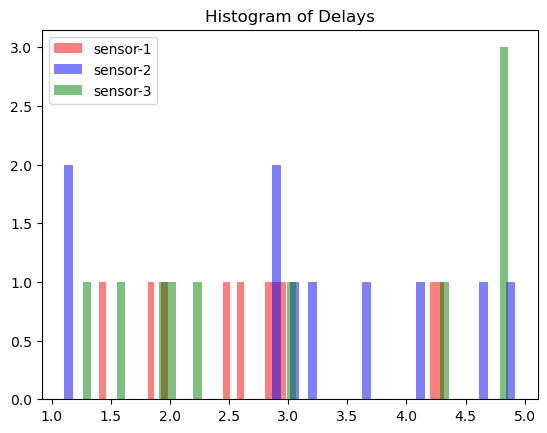

In [7]:
import matplotlib.pyplot as plt

plt.hist(list_delay_1, alpha=0.5, label="sensor-1", color="red", bins=50)
plt.hist(list_delay_2, alpha=0.5, label="sensor-2", color="blue", bins=50)
plt.hist(list_delay_3, alpha=0.5, label="sensor-3", color="green", bins=50)
plt.title("Histogram of Delays")
plt.legend()
plt.show()